# What is fast.ai and why use it?

[fast.ai](https://www.fast.ai/) is essentially a high-level wrapper for PyTorch, simplifying training fast and accurate neural nets using modern best practices.

Developed by [Jeremy Howard, Rachel Thomas and Sylvain Gugger](https://www.fast.ai/about/), fastai is based on active research into deep learning best practices - meaning a lot of useful tools are built in to the library.

fast.ai has a lot of extremely useful tutorials available on their website at [fast.ai/](https://www.fast.ai/).

In this notebook, we will leverage a number of these advanced functionalities:
- Learning rate finder
- Easy transfer learning
- [Weight decay](https://forums.fast.ai/t/new-adamw-optimizer-now-available/8518/3)
- Optimized [one cycle policy](https://docs.fast.ai/callbacks.one_cycle.html)
 - In phase 1, the learning rates goes from lr_max/div_factor to lr_max linearly while the momentum goes from moms[0] to moms[1] linearly.
 - In phase 2, the learning rates follows a cosine annealing from lr_max to 0, as the momentum goes from moms[1] to moms[0] with the same annealing.
- Multilabel Stratification
  - Thanks to [here](https://www.kaggle.com/ronaldokun/multilabel-stratification)
- [Modern pretrained CNN architectures](https://github.com/rwightman/gen-efficientnet-pytorch)
- [Transfer learning](https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb) to these CNN architectures

# Data

In [ ]:
DATA_DIR = '/content/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '/content/submission.csv'   # Contains dummy labels for test image

Google colabs has some issues with the latest version of pytorch/torchvision so we will suppress warnings

In [ ]:
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')
#!pip install "torch==1.4" "torchvision==0.5.0"
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.5MB/s 


/usr/local/lib/python3.6/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.6/dist-packages/scikit_multilearn-0.2.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:
warnings.filterwarnings(action='ignore')

# Base Code

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#!pip install git+https://github.com/fastai/fastai
from fastai.vision import *
import fastai
#print(fastai.__version__)
import fastai.utils.collect_env;
#fastai.utils.collect_env.show_install(1)
#1.0.47 dev pass

from torchvision.models import *
from fastai.torch_core import flatten_model
from fastai.layers import CrossEntropyFlat
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.callbacks import *
from fastai.callbacks.tracker import *

In [ ]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)
            group = []


In [ ]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

# Set Up Data

## Transforms


[Randomly masking square sections](https://arxiv.org/pdf/1708.04552.pdf)
of the image performed equivalently (to targeted masking) in the experiments we
conducted. Importantly, this simple regularizer proved to be
complementary to existing forms of data augmentation and
regularization.
- Using a combination of corrupted and
clean images appears to be important for its success.
- Alternatively, if the cutout is allowed to land at any point in the image (i.e. even fall mainly outside of the image), then a cutout can always be applied.

Interestingly, it appears that as the number of classes increases, the optimal cutout size decreases.
This makes sense, as when more fine-grained detection is
required then the context of the image will be less useful
for identifying the category. Instead, smaller and more nuanced details are important.

- CIFAR 10 (10 Classes) - 16x16px from 32x32px
- CIFAR 100 (100 Classes) - 8x8px from 32x32px

Hence, for our case - we 10 classes, so try a maximum cutout length of length/2.
i.e.
- for 256 px - 128px
- for 512 px - 256 px

In [ ]:
max_rotate = 180
max_warp = 0
max_zoom = 1.05
max_lighting = 0.05
p_affine = 0.8
p_lighting = 0.5


tfms256 = [pad(padding=4, mode='reflection'),
        rotate(degrees=(-max_rotate, max_rotate), p=p_affine),
        #symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine, invert=False),
        rand_zoom(scale=(1.,max_zoom), p=p_affine),
        brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting, use_on_y=False),
        contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting, use_on_y=False),
        cutout(n_holes=(1,1), length=(100,128), p=1),
        ]

tfms512 = [pad(padding=8, mode='reflection'),
        rotate(degrees=(-max_rotate, max_rotate), p=p_affine),
        #symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine, invert=False),
        #rand_zoom(scale=(1.,max_zoom), p=p_affine),
        brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting, use_on_y=False),
        contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting, use_on_y=False),
        cutout(n_holes=(1,1), length=(200,256), p=1),
        ]

tfms256_y = [pad(padding=4, mode='reflection')]
tfms512_y = [pad(padding=8, mode='reflection')]

In [ ]:
stats = ([0.0793, 0.0530, 0.0545], [0.1290, 0.0886, 0.1376])

# Multi-Label Classification

Many classes are under-represented, compared to the majority classes 4 and 6.
Multi-label stratification may help our model, by ensuring that each class is properly represented during the train/validation split.

A random split may end up being unlucky.

4    9066
6    5711
7    2629
2    2542
0    2088
3    1977
1    1752
9    1278
5    1109
8    1037
Name: Label, dtype: int64


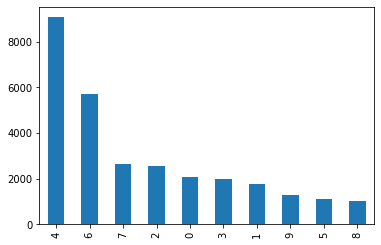

In [ ]:
df = pd.read_csv('/content/Human protein atlas/train.csv').set_index("Image")
df['Label'] = df.Label.str.split(" ")
df = df.explode('Label')
df.Label.value_counts().plot(kind='bar');
print(df.Label.value_counts())

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [ ]:
df = pd.read_csv('/content/Human protein atlas/train.csv')
onehotencoded_labels = pd.DataFrame(mlb.fit_transform(df['Label']))

In [ ]:
onehotencoded_labels.drop(0,axis=1, inplace=True)
onehotencoded_labels.columns = labels.keys()
encodedlabel_df = df.join(onehotencoded_labels)

In [ ]:
from skmultilearn.model_selection import IterativeStratification
X, y = encodedlabel_df['Image'], encodedlabel_df.iloc[0:,2:].values
k_fold = IterativeStratification(n_splits=5, order=1, random_state = 101)

splits = list(k_fold.split(X, y))

This has split our data into 5-fold train/validation splits.
Each array has 2 dimensions, the 1st dimension are the indices of our training set ( 80% of the data ) and the second dimension are the indices of our validation set (20% of the data).

In [ ]:
print(splits[0][0].shape , splits[0][1].shape)
print(splits[1][0].shape , splits[1][1].shape)
print(splits[2][0].shape , splits[2][1].shape)
print(splits[3][0].shape , splits[3][1].shape)
print(splits[4][0].shape , splits[4][1].shape)

(15384,) (3852,)
(15405,) (3831,)
(15372,) (3864,)
(15377,) (3859,)
(15406,) (3830,)


We now set up use of the first fold.

In [ ]:
fold = 0

train_df = df.loc[splits[fold][0]]
val_df = df.loc[splits[fold][1]]
train_df['is_valid'] = False
val_df['is_valid'] = True
fold_0 = train_df.append(val_df)

# Prepare Data with data_block API

We will be using the [data_block API](https://docs.fast.ai/data_block.html) to prepare our data.

- splitting data
- defining label for each image
- specify training transforms
- creating a databunch
- normalization based on entire dataset stats

Note that you should validate only on the original images.
The augmentation is there so that it can help your model generalize better, but to evaluate your model you need actual images, not transformed ones.
The above process does this automatically, only applying the transforms to both if tfm_y is among them and if set to True.




In [ ]:
np.random.seed(42)
test = (ImageList.from_folder(TEST_DIR))

data256= (ImageList.from_df(fold_0, path='/content/Human protein atlas/train', suffix='.png')        #Where to find the data? -> in path and its subfolders
        #.use_partial_data(0.005)                                                          #Use partial data for model evaluation
        .split_from_df()                                                                  #How to split in train/valid? -> randomly, 20% for validation
        .label_from_df(label_delim=' ')                                                   #How to label? -> depending on the dataframe                                                          #Optionally add a test set (here default name is test)
        .transform([tfms256, tfms512_y], size=(256,256), padding_mode='reflection')    # Tuple forces crop                                            #Data augmentation? By default does not transform the validation set
        .add_test(test)                                                                   #Test set added to the final dataset.
        .databunch(num_workers=4, bs=64)                                                   #Finally? -> conversion to ImageDataBunch
        .normalize(stats))                                                                #Normalize data using stats previously calculated

data512= (ImageList.from_df(fold_0, path='/content/Human protein atlas/train', suffix='.png')        #Where to find the data? -> in path and its subfolders
        #.use_partial_data(0.005)                                                          #Use partial data for model evaluation
        .split_from_df()                                                                  #How to split in train/valid? -> randomly, 20% for validation
        .label_from_df(label_delim=' ')                                                   #How to label? -> depending on the dataframe                                                          #Optionally add a test set (here default name is test)
        .transform([tfms512, tfms512_y], size=(512,512), padding_mode='reflection')   #Data augmentation? By default does not transform the validation set
        .add_test(test)                                                                   #Test set added to the final dataset.
        .databunch(num_workers=4, bs=16)                                                   #Finally? -> conversion to ImageDataBunch
        .normalize(stats))                                                                #Normalize data using stats previously calculated

## Sanity Check

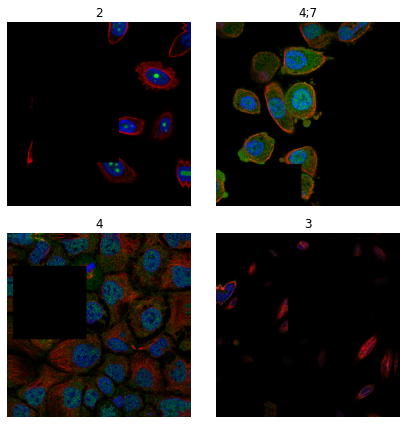

In [ ]:
data512.show_batch(rows=2, figsize=(6,6))

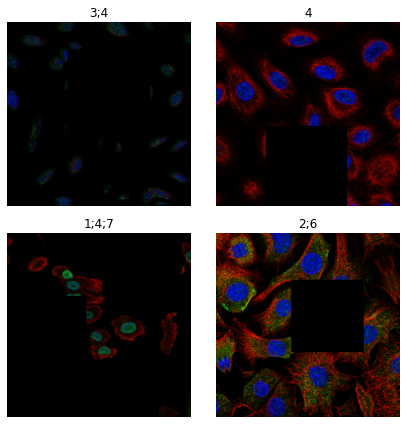

In [ ]:
data256.show_batch(rows=2, figsize=(6,6))

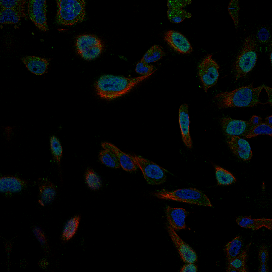

In [ ]:
# We can assure ourselves that the validation dataset is not augmented by looking directly at the validation set
data256.valid_ds[5][0]
# No cutout!

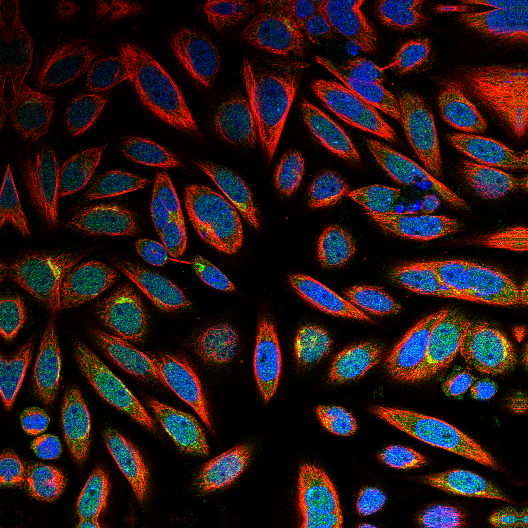

In [ ]:
data512.test_ds[5][0]
# Test dataset also loaded

#  Create Model
[FastAI](https://myndbook.com/view/6278) is a wrapper for PyTorch that provides many convenient functions.


## Model Structure

One of greatest techniques fast.ai uses heavily is called [discriminative layer training](https://docs.fast.ai/basic_train.html#Discriminative-layer-training), which is to use apply different learning rates to different layers. The idea is, what the first few layers learn is more task-independent, so we don't want to change them too much from the pretrained weights; we'd like to train more for the last few layers added by us.

For this model - we'd like to simply discriminate by freezing the body of the model and training the head when we like to. Here's a great [resource](https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb).

In [ ]:
#Lets see a basic overview of the architecture
arch_summary(resnet34)

(0) Conv2d      : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) ReLU        : 1   layers (total: 3)
(3) MaxPool2d   : 1   layers (total: 4)
(4) Sequential  : 15  layers (total: 19)
(5) Sequential  : 22  layers (total: 41)
(6) Sequential  : 32  layers (total: 73)
(7) Sequential  : 17  layers (total: 90)
(8) AdaptiveAvgPool2d: 1   layers (total: 91)
(9) Linear      : 1   layers (total: 92)


We can see that the last layer of the CNN is simply linear with 1000 output features. We'll cut this out and simply replace it with 10 outputs. No point re-inventing the wheel.

In [ ]:
# Create our own custom head/classifier network using pytorch syntax
class CustomClassifier(nn.Module):
    def __init__(self, in_features = 512, intermed_bn = 512, out_features=10, dout=0.25):
        super().__init__()
        self.customclassifier = nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(in_features*2),
            nn.Dropout(dout),
            nn.Linear(in_features*2, intermed_bn, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(intermed_bn, momentum=0.01),
            nn.Dropout(dout*2),
            nn.Linear(in_features, out_features, bias=True))

    def forward(self, xb):
        return self.customclassifier(xb)

## Create Model with cnn_learner

In [ ]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
accuracy = partial(accuracy_thresh, thresh=0.3)
f_score = partial(F_score, beta=1, threshold=0.3) # Beta = 1, as kaggle uses macro F1 Score
# Create learner - begin with the 256px data
learn = cnn_learner(data256,
                    resnet34, #This architecture must be uninitialized. It is initialized in this learner builder with a pretrained arg.
                    custom_head=CustomClassifier(),
                    pretrained=True,
                    cut = -2,
                    wd = 1e-4,
                    metrics=[accuracy, f_score],
                    model_dir=DATA_DIR+'/working/',
                    callback_fns=[partial(EarlyStoppingCallback, monitor='F_score', min_delta=0.01, patience=5),
                                  partial(SaveModelCallback, every='improvement', monitor='F_score', name='best'),
                                  partial(CSVLogger, append=True)]
                    )


# Note that the cnn_learner call creates it's own custom head, here we are specifying which custom head to use
  # CustomClassifier must have the in_features specified as the output of the last layer just before the classifier
  # In the case of densenet121, this is a BatchNorm2d with 1024 outputs.
# Callback_fns take functions - hence we've used partial functions

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

# Train Network

In [ ]:
# don't forget to remove the old file
try:
  if learn.csv_logger.path.exists(): os.remove(learn.csv_logger.path)
except:
  pass

## Transfer Learning Step 1

Transfer Learning Step 1 - 240x240 pixels

At this point we will begin a simple progressive resizing transfer learning procedure.
- Freeze model except for head
- Find optimal learning rate
- Fit using one cycle policy
  - Note that this has built in momentum cycling
- Unfreeze model
- Find new optimal learning rate
- Fit using one cycle policy

- Update data to use full-size data
- Repeat all of above

In [ ]:
learn.freeze()
total_params = sum(p.numel() for p in learn.model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

21,817,674 total parameters.
550,026 training parameters.


epoch,train_loss,valid_loss,accuracy_thresh,F_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.74E-02


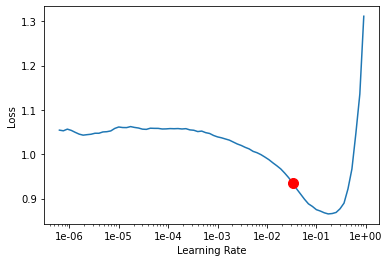

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 3.31E-02 # Steepest point of decline

In [ ]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy_thresh,F_score,time
0,0.352121,0.343099,0.859242,0.449751,02:20
1,0.299595,0.404056,0.813967,0.352469,02:19
2,0.295607,0.322178,0.869341,0.488872,02:20
3,0.294046,0.407091,0.848235,0.576080,02:19
4,0.292544,0.329724,0.844081,0.539746,02:18
5,0.270803,0.272307,0.880010,0.541999,02:19
6,0.262125,0.248141,0.889979,0.585472,02:19
7,0.245467,0.252815,0.893458,0.597635,02:19
8,0.240813,0.237267,0.899922,0.594975,02:22
9,0.237864,0.240972,0.899351,0.605840,02:21


Better model found at epoch 0 with F_score value: 0.4497514069080353.
Better model found at epoch 2 with F_score value: 0.48887181282043457.
Better model found at epoch 3 with F_score value: 0.5760800838470459.
Better model found at epoch 6 with F_score value: 0.585472047328949.
Better model found at epoch 7 with F_score value: 0.5976351499557495.
Better model found at epoch 9 with F_score value: 0.6058395504951477.


Fine tune the network

In [ ]:
learn.load('/content/Human protein atlas/working/best');

In [ ]:
learn.unfreeze()
total_params = sum(p.numel() for p in learn.model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

21,817,674 total parameters.
21,817,674 training parameters.


epoch,train_loss,valid_loss,accuracy_thresh,F_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


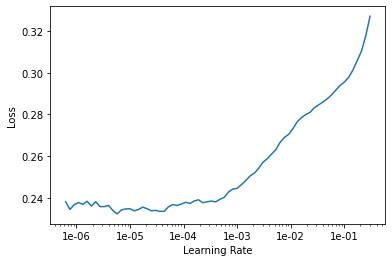

In [ ]:
learn.lr_find()
learn.recorder.plot()

 So we will define a range of learning rates using the rule of thumb: ending at the “secure” rate 1e-5 and starting at a rate that is one order of magnitude higher: max_lr=slice().

In [ ]:
learn.fit_one_cycle(25, slice(2e-6, 2e-5)) # This slice should be the plateau before the rise, around 1 orders of magnitude

epoch,train_loss,valid_loss,accuracy_thresh,F_score,time
0,0.234449,0.240005,0.897975,0.605649,02:20
1,0.233328,0.238447,0.899169,0.605556,02:20
2,0.230813,0.235415,0.901116,0.606163,02:20
3,0.234382,0.238125,0.899792,0.608529,02:20
4,0.233187,0.235335,0.901402,0.605084,02:20
5,0.231565,0.236086,0.901636,0.611652,02:20


Better model found at epoch 0 with F_score value: 0.6056494116783142.
Better model found at epoch 2 with F_score value: 0.6061627864837646.
Better model found at epoch 3 with F_score value: 0.6085287928581238.
Better model found at epoch 5 with F_score value: 0.6116518974304199.
Epoch 6: early stopping


### View and Plot Progress

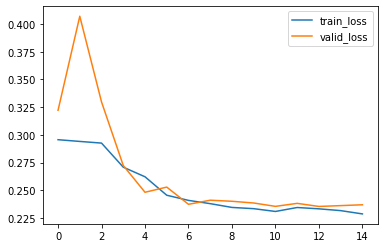

In [ ]:
progress_log = learn.csv_logger.read_logged_file().dropna()[['train_loss','valid_loss']][2:]
progress_log.reset_index(drop=True).apply(pd.to_numeric).plot();


In [ ]:
from google.colab import files
files.download('/content/Human protein atlas/working/best.pth')

## Transfer Learning Step 2 - 512x512px

In [ ]:
learn.load('/content/Human protein atlas/working/best');

In [ ]:
learn.data = data512
#data.train_ds[0][0].shape

In [ ]:
learn.freeze()
total_params = sum(p.numel() for p in learn.model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

21,817,674 total parameters.
550,026 training parameters.


epoch,train_loss,valid_loss,accuracy_thresh,F_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 7.59E-04


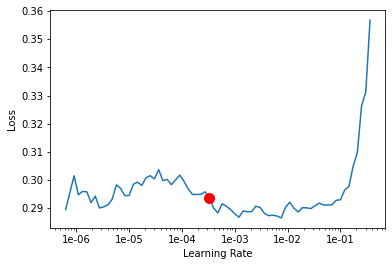

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, 3.31e-4) # Adjust learning rate to some secure point in plateau/slight reduction

epoch,train_loss,valid_loss,accuracy_thresh,F_score,time
0,0.276144,0.356847,0.890135,0.538445,04:08
1,0.254200,0.317607,0.895613,0.572358,04:10
2,0.242275,0.289029,0.900000,0.599282,04:09
3,0.245823,0.280799,0.904050,0.608430,04:09
4,0.246496,0.413305,0.905478,0.610630,04:12
5,0.238353,0.319994,0.906879,0.619084,04:15
6,0.237221,0.306102,0.907191,0.618891,04:12
7,0.239491,0.356642,0.906386,0.621443,04:14
8,0.235144,0.387110,0.908333,0.619435,04:12
9,0.237256,0.297646,0.907269,0.618099,04:14


Better model found at epoch 0 with F_score value: 0.538444995880127.
Better model found at epoch 1 with F_score value: 0.5723583698272705.
Better model found at epoch 2 with F_score value: 0.5992817878723145.
Better model found at epoch 3 with F_score value: 0.6084304451942444.
Better model found at epoch 4 with F_score value: 0.6106298565864563.
Better model found at epoch 5 with F_score value: 0.619083821773529.
Better model found at epoch 7 with F_score value: 0.6214427351951599.


In [ ]:
from google.colab import files
files.download('/content/Human protein atlas/working/best.pth')

In [ ]:
learn.load('/content/Human protein atlas/working/best');

In [ ]:
learn.unfreeze()
total_params = sum(p.numel() for p in learn.model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

21,817,674 total parameters.
21,817,674 training parameters.


epoch,train_loss,valid_loss,accuracy_thresh,F_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


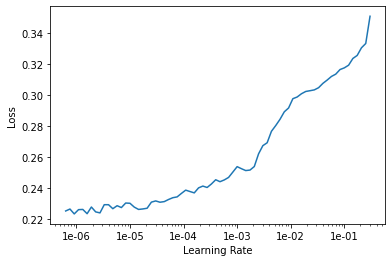

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(1e-06)) # Small to big !!!

epoch,train_loss,valid_loss,accuracy_thresh,F_score,time
0,0.241935,0.356321,0.907373,0.625452,04:23
1,0.239078,0.294286,0.908489,0.620309,04:21
2,0.234253,0.227603,0.907658,0.620241,04:21
3,0.237829,0.338001,0.908412,0.623726,04:23
4,0.238575,0.451335,0.907529,0.620011,04:23
5,0.227660,0.288837,0.907477,0.626475,04:22


Better model found at epoch 0 with F_score value: 0.6254521012306213.
Better model found at epoch 5 with F_score value: 0.6264750957489014.
Epoch 6: early stopping


In [ ]:
from google.colab import files
files.download('/content/Human protein atlas/working/best.pth')

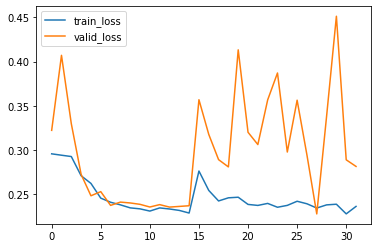

In [ ]:
progress_log = learn.csv_logger.read_logged_file().dropna()[['train_loss','valid_loss']][2:]
progress_log.reset_index(drop=True).apply(pd.to_numeric).plot();


# Export


In [ ]:
learn.export()

# What is Test Time Augmentation?

Test time augmentation or TTA is the application of transforms to the test data before prediction. This is done five fold, then the probabilities of each class are averaged, then returned.


In [ ]:
doc(Learner.TTA)

[Internally](https://github.com/fastai/fastai/blob/master/fastai/vision/tta.py#L32), the Learner.TTA(test_data) method calls a _tta_only function, that applies image augmentation transforms. Then, a _TTA function is called which uses these defined transformations, puts the output together in a list, averages and returns the final predictions.

The default transforms utilize the transforms that you applied to the training data, to replicate what kind of data the model is used to seeing.
The default transforms can be seen below:

In [ ]:
augm_tfm = [o for o in learn.data.train_ds.tfms if o.tfm not in (crop_pad, flip_lr, dihedral, zoom)]

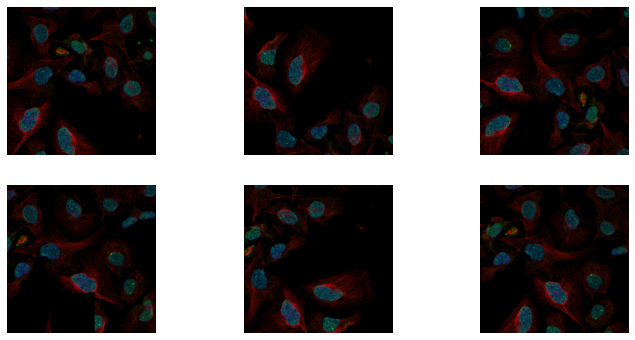

In [ ]:
row = 0
col = 1
flip = 0
scale = 1.35 #default scale is 1.35 - probably too large, so setting to 1.0 for real TTA

d = {'row_pct':row, 'col_pct':col, 'is_random':False}
tfm = [*augm_tfm, zoom(scale=scale, **d), crop_pad(**d)]

def plots_tfms(im, rows, cols, width, height, **kwargs):
    [im.apply_tfms(tfm, **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

img = data512.valid_ds[1][0]

plots_tfms(img, 2, 3, 12, 6)

TTA prediction return probabilities, not the last activations (because they took the average of the probabilities with different data augmentation)

# Predict

Because of rare classes, macro F1 score (the metric used by Kaggle for this competition) is very sensitive to thresholds.

Hence we'd like to do a little bit of threshold manipulation to maximise the validation score we get for our trained model.


## Validation Score

Generate predictions on the validation set with using learn.get_preds (no test time augmentation).

In [ ]:
val_preds, y = learn.get_preds()

These predictions are a list of tensors, one element for each class.
Each of these elements represent the probability (having been passed through a sigmoid function) of each class being present.

In [ ]:
print(y[0])
print(val_preds[0])

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([8.7069e-04, 4.6553e-01, 1.1036e-03, 4.5171e-02, 6.3127e-01, 2.0751e-05,
        1.5553e-01, 2.9640e-01, 5.5863e-02, 3.5102e-03])


## Calculate Best Thresholds

## Flat Thresholds

In [ ]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
F_score(val_preds, y, threshold=0.2)

tensor(0.8776)

In [ ]:
doc(fbeta)

In [ ]:
f_scores = []
threshold_range = np.arange(0,1,0.01)
for t in threshold_range:
  f1_score = F_score(val_preds, y, threshold=t)
  f2_score = F_score(val_preds, y, threshold=t, beta=2)
  f_scores.append([t, float(f1_score), float(f2_score), float(f1_score_2)])

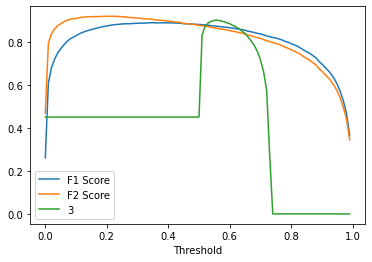

In [ ]:
f_scores = pd.DataFrame(f_scores).rename({0:'Threshold',1:'F1 Score',2:'F2 Score'},axis=1).set_index('Threshold')
f_scores.plot();

In [ ]:
#Best threshold value for this data
f_scores[f_scores['F1 Score']== f_scores['F1 Score'].max()]

,F1 Score,F2 Score,3
Threshold,,,
0.35,0.89215,0.907935,0.45179


In [ ]:
#Best threshold value for this data
f_scores[f_scores['F2 Score']== f_scores['F2 Score'].max()]

,F1 Score,F2 Score,3
Threshold,,,
0.21,0.879762,0.922322,0.45179


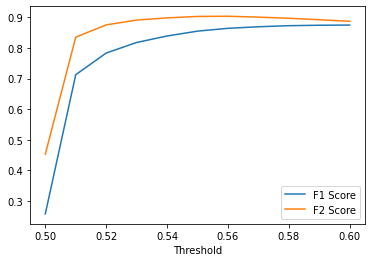

In [ ]:
f_scores.loc[0.5:0.6].plot();

In [ ]:
from scipy.optimize import minimize
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y, beta = 2) # F2-Score
scipy.optimize.Bounds(0,1)
res = minimize(f_score_complement, 0.5,
               method='powell',
               bounds=(0,1),
               options={'xtol': 1e-8})
res.x # Optimized F2-Score threshold

print(f'The best F2-Score is {1-res.fun}, at threshold {res.x}')

The best F2-Score is 0.4615705907344818, at threshold -1.1180319340237879


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)


In [ ]:
from scipy.optimize import minimize
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y, beta = 1) # F1-Score
scipy.optimize.Bounds(0,1)
res = minimize(f_score_complement, 0.54,
               method='powell',
               options={'xtol': 1e-5})
res.x # Optimized F2-Score threshold

print(f'The best F1-Score is {1-res.fun}, at threshold {res.x}')

The best F1-Score is 0.480701744556427, at threshold 0.5397429190855988


## Individual thresholds

To do this, we take the default fbeta function defined in the fast.ai documentation, and alter it such that the main variable taken in is the threshold vector.

In [ ]:
def fbeta_custom(thresh:float, y_pred:Tensor=preds, y_true:Tensor=y, beta:float=2, eps:float=1e-9, sigmoid:bool=True)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>torch.tensor(thresh)).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return 1-float(res.mean())

In [ ]:
threshold_categories

[0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54]

In [ ]:
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y)
f_score_complement(threshold_categories)

0.4560263752937317

In [ ]:
import scipy.optimize as opt
best_threshold = f_scores[f_scores['F1 Score']== f_scores['F1 Score'].max()].index[0]
threshold_categories = [best_threshold]*10



In [ ]:
# Optimize F1-Score
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y, beta = 1) # F1-Score
res = minimize(f_score_complement, threshold_categories,
               method='powell',
               options={'xtol': 1e-8})

print(f'The best F1-Score is {1-res.fun}, at threshold {res.x}')

The best F1-Score is 0.5350877642631531, at threshold [0.534975 5.776061 0.54     5.776061 0.556772 5.776061 0.531371 5.776061 5.776061 5.776061]


In [ ]:
# Optimize F1-Score
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y, beta = 2) # F2-Score
res = minimize(f_score_complement, threshold_categories,
               method='powell',
               options={'xtol': 1e-8})

print(f'The best F2-Score is {1-res.fun}, at threshold {res.x}')

The best F2-Score is 0.6310531497001648, at threshold [ 0.54      8.394092 -0.1682    8.394092  0.662464  8.394092  0.523932  0.505422  8.394092  8.394092]


# Generate Predictions

In [ ]:
#learn_test = load_learner(DATA_DIR, test=test, num_workers=0, bs=32) # Load model
#learn_test.load('/content/Human protein atlas/working/best'); # Load weights
learn.load('/content/Human protein atlas/working/best'); # Load best weights into our model

In [ ]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tta, _ = learn.TTA(ds_type=DatasetType.Test, scale = 1.0)

In [ ]:
preds.shape

torch.Size([19, 10])

In [ ]:
print(preds[:5])

tensor([[1.0764e-04, 7.7319e-02, 6.1337e-02, 2.9880e-02, 7.0191e-01, 1.6038e-02,
         9.7360e-01, 2.5840e-01, 6.4447e-04, 4.7207e-03],
        [2.3043e-02, 4.9420e-02, 1.4508e-04, 2.2271e-01, 3.4343e-02, 7.0364e-05,
         4.2099e-01, 4.1233e-01, 3.0625e-06, 2.2543e-02],
        [2.4453e-05, 9.0583e-03, 2.6047e-01, 1.5500e-02, 9.9936e-01, 1.4962e-06,
         1.7289e-02, 2.2027e-01, 3.5321e-08, 4.1383e-03],
        [2.4768e-03, 8.9271e-02, 1.0241e-03, 2.5458e-02, 9.7610e-01, 4.8692e-02,
         9.7845e-01, 7.7217e-06, 7.5819e-04, 1.2271e-03],
        [6.1588e-03, 4.6229e-03, 3.9094e-02, 3.2171e-01, 9.9996e-01, 7.9497e-04,
         9.7119e-02, 1.5990e-05, 3.4768e-04, 1.8800e-04]])


Look at proportion of label predictions

In [ ]:
labels = labelled_preds
label_count = np.zeros(10)
for label in labels['Label']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(10)[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

NameError: ignored

# Generate CSV

In [ ]:
thresh = 0.35
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = [f.name[:-4] for f in learn.data.test_ds.x.items]
df = pd.DataFrame({'Image':fnames, 'Label':labelled_preds}, columns=['Image', 'Label'])
df.to_csv('fastai_efficientnet_035.csv', index=False)


In [ ]:
thresh = 0.35
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds_tta]
fnames = [f.name[:-4] for f in learn.data.test_ds.x.items]
df = pd.DataFrame({'Image':fnames, 'Label':labelled_preds}, columns=['Image', 'Label'])
df.to_csv('fastai_efficientnet_TTA_035.csv', index=False)


In [ ]:
thresh = 0.21
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = [f.name[:-4] for f in learn.data.test_ds.x.items]
df = pd.DataFrame({'Image':fnames, 'Label':labelled_preds}, columns=['Image', 'Label'])
df.to_csv('fastai_efficientnet_021.csv', index=False)


In [ ]:
thresh = 0.21
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds_tta]
fnames = [f.name[:-4] for f in learn.data.test_ds.x.items]
df = pd.DataFrame({'Image':fnames, 'Label':labelled_preds}, columns=['Image', 'Label'])
df.to_csv('fastai_efficientnet_TTA_021.csv', index=False)


# Notes

 Densenet 121 - 5% data - 0.7124130725860596 F2 Score -